In [1]:
import numpy as np
import pandas as pd

import os
print(os.listdir("input"))

['fruits-360', 'readme.md']


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import load_files
import torch.optim as optim
import os
import numpy as np
import time
from PIL import Image
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import matplotlib.pyplot as plt
import copy
from glob import glob

In [3]:
path = 'input/fruits-360'

In [4]:
files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
files_testing = glob(os.path.join(path, 'Test', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)
print(len(files_testing))

Number of images in Training file: 59328
20232


In [5]:
min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < min_images):
        min_images = folder_num
        folder_name = folder
        
num_classes = len(class_names)
print("\nMinumum imgages per category:", min_images, 'Category:', folder)    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
Cocos                490
Hazelnut             464
Apple Red Yellow 2   672
Apple Golden 2       492
Cherry Wax Black     492
Grape White 3        492
Limes                490
Apple Red Delicious  490
Nut Forest           218
Kohlrabi             471
Pear Kaiser          300
Rambutan             492
Kaki                 490
Maracuja             490
Pepino               490
Physalis with Husk   492
Papaya               492
Apple Braeburn       492
Pear Abate           490
Cherry 2             738
Onion White          438
Cantaloupe 2         492
Apple Golden 3       481
Chestnut             450
Apple Red 1          492
Grape Blue           984
Pepper Yellow        666
Tomato Cherry Red    492
Mangostan            300
Cantaloupe 1         492
Ginger Root          99
Tomato Maroon        367
Cherry Rainier       738
Apple Red 3          429
Potato Sweet         450
Mango                490
Kiwi                 466
Mandarine            490
Q

In [6]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])
all_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)

input/fruits-360/Training
Dataset ImageFolder
    Number of datapoints: 59328
    Root location: input/fruits-360/Training
    StandardTransform
Transform: Compose(
               ToTensor()
           )
['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_find_classes', '_format_transform_repr', '_repr_indent', 'class_to_idx', 'classes', 'extensions', 'extra_repr', 'imgs', 'loader', 'root', 'samples', 'target_transform', 'targets', 'transform', 'transforms']


In [7]:
data_loader = torch.utils.data.DataLoader(all_data, batch_size=512, shuffle=True)
# for inputs, labels in dataloaders['train']:
#     print(inputs)
#     print('*' * 30, '\n')
#     print(labels)

In [8]:
pop_mean = []
pop_std = []

for i, data in enumerate(data_loader, 0):
#     print(i, data[0].numpy())
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    pop_mean.append(batch_mean)
    pop_std.append(batch_std)

pop_mean = np.array(pop_mean).mean(axis=0)
pop_std = np.array(pop_std).mean(axis=0)


In [9]:
print(pop_mean)
print(pop_std)

[0.6835035 0.5716193 0.492941 ]
[0.30043432 0.3572633  0.38759455]


In [10]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)
print(shuffle, len(shuffle))

[30889 28216  7132 ... 28030 15725 52734] 59328


In [11]:
split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number of valid images after split:',len(shuffle[:split_val]))
print('Number of train images after split:',len(shuffle[split_val:]))

Total number of images: 59328
Number of valid images after split: 11865
Number of train images after split: 47463


In [12]:
from torch.utils.data import Dataset
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [13]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset('input/fruits-360/Test', class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [14]:
print(train_loader)
print(iter(train_loader))
print(dir(train_loader))

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_index_sampler', 'batch_sampler', 'batch_size', 'collate_fn', 'dataset', 'dataset_kind', 'drop_last', 'multiprocessing_context', 'num_workers', 'pin_memory', 'sampler', 'timeout', 'worker_init_fn']


In [15]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = pop_std * inp + pop_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

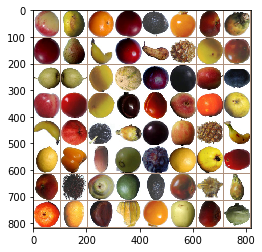

['Cherry Rainier', 'Pomelo Sweetie', 'Tomato Yellow', 'Cherry Wax Red', 'Avocado ripe', 'Physalis', 'Nectarine Flat', 'Cactus fruit', 'Cherry Wax Red', 'Pear Forelle', 'Banana', 'Tamarillo', 'Pear Abate', 'Pineapple Mini', 'Peach 2', 'Tomato Maroon', 'Pear', 'Pear', 'Peach 2', 'Cantaloupe 2', 'Plum 2', 'Grape Blue', 'Apple Pink Lady', 'Blueberry', 'Cherry Rainier', 'Tomato 4', 'Peach 2', 'Cherry 1', 'Tomato 1', 'Peach Flat', 'Clementine', 'Pear Monster', 'Banana', 'Pear Red', 'Mulberry', 'Cactus fruit', 'Cherry Wax Black', 'Apple Pink Lady', 'Pineapple Mini', 'Banana Lady Finger', 'Lemon', 'Pepper Yellow', 'Hazelnut', 'Grape White 4', 'Dates', 'Grapefruit White', 'Quince', 'Tomato 2', 'Nectarine Flat', 'Rambutan', 'Pear Williams', 'Mango', 'Avocado ripe', 'Tomato Maroon', 'Physalis with Husk', 'Cactus fruit', 'Clementine', 'Kumquats', 'Chestnut', 'Physalis with Husk', 'Physalis', 'Apple Golden 2', 'Nectarine Flat', 'Kohlrabi']


In [17]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

fruits = ['' for x in range(len(classes))]
for i in range(len(classes)):
    fruits[i] = class_names[classes[i].item()]
    
imshow(out)
print(fruits)

In [18]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_bn = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 10 * 10, 250)
        self.fc2 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = x.view(-1, 64 * 10 * 10)
        x = F.dropout(F.relu(self.fc1(x)), training=self.training, p=0.4)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1) 

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
from torchsummary import summary
model = Net(num_classes)
model.to(device)
summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]           1,216
       BatchNorm2d-2           [-1, 16, 96, 96]              32
         MaxPool2d-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 32, 46, 46]           4,640
       BatchNorm2d-5           [-1, 32, 46, 46]              64
         MaxPool2d-6           [-1, 32, 23, 23]               0
            Conv2d-7           [-1, 64, 21, 21]          18,496
       BatchNorm2d-8           [-1, 64, 21, 21]             128
         MaxPool2d-9           [-1, 64, 10, 10]               0
           Linear-10                  [-1, 250]       1,600,250
           Linear-11                  [-1, 118]          29,618
Total params: 1,654,444
Trainable params: 1,654,444
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forw

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9)
from torch.optim.lr_scheduler import *
scheduler=StepLR(optimizer,step_size=3)

In [22]:
def train(model,device, train_loader, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        x,y= data
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        y_hat= model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    print ('Train Epoch: {}\t Loss: {:.6f}'.format(epoch,loss.item()))

In [23]:
def valid(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for i,data in enumerate(valid_loader):          
            x,y= data
            x=x.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            valid_loss += criterion(y_hat, y).item() # sum up batch loss
            pred = y_hat.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()
    valid_loss /= len(valid_loader.dataset)
    print('\nValid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_dataset),
        100. * correct / len(valid_dataset)))

In [ ]:
for epoch in range(1, 100):
    train(model=model, device=device, train_loader=train_loader, epoch=epoch)
    valid(model=model, device=device, valid_loader=valid_loader)

Train Epoch: 1	 Loss: 0.564112

Test set: Average loss: 0.0022, Accuracy: 11386/11865 (96%)

Train Epoch: 2	 Loss: 0.164411

Test set: Average loss: 0.0012, Accuracy: 11528/11865 (97%)

Train Epoch: 3	 Loss: 0.266000

Test set: Average loss: 0.0004, Accuracy: 11796/11865 (99%)

Train Epoch: 4	 Loss: 0.074146

Test set: Average loss: 0.0003, Accuracy: 11771/11865 (99%)

